The given data consists of two collumes. The first collume represents time in seconds each photon arrived to the detector from the momment the detector started counting and the second collume represents the energy of the photons in GeV.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize as spopt
import scipy.interpolate as spinterp
import scipy.integrate as spint
import pandas as pd

First we have to import the data and check that, that has happened successfully.

In [2]:
data_1=np.genfromtxt('Sidiras_grb1.txt',dtype=float,usecols=(0,1),names=('Time','Energy'))
data_2=np.genfromtxt('Sidiras_grb2.txt',dtype=float,usecols=(0,1),names=('Time','Energy'))
data_3=np.genfromtxt('Sidiras_grb3.txt',dtype=float,usecols=(0,1),names=('Time','Energy'))
data_4=np.genfromtxt('Sidiras_grb4.txt',dtype=float,usecols=(0,1),names=('Time','Energy'))
print(data_1.dtype.names)
print(data_2.dtype.names)
print(data_3.dtype.names)
print(data_4.dtype.names)

('Time', 'Energy')
('Time', 'Energy')
('Time', 'Energy')
('Time', 'Energy')


## Task 1

We are going to create a spectrum for each data set. We start from data set 1. First we need to define a function that rebins the spectrum to a minimum bin count as it was defined in the lecture notes.

In [3]:
def histrebin(mininbin,counts,edges):
    
    edges2=np.zeros(1)
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  
            if firstbin_flag == 1:
                counts2[0]=countsum
                firstbin_flag = 0
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        
    return counts2, edges2

We are now dividing our energy into bins that represent counts. In other words we are calculating how many energy points there are in a given energy range.

In [4]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_1['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

Now we are going to plot our data to get a first impresion.

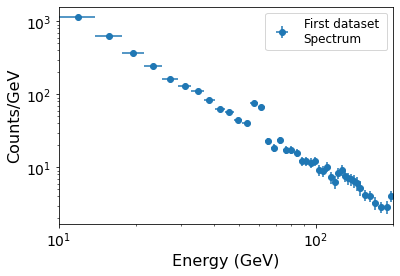

In [5]:
plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='First dataset \nSpectrum')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               

At first impresion we can see a background and upon the background at about 60 GeV there might be an emision line we have to take a closer look by fitting  the background first and considering the data/model ratio. In order to do the fitting we have to introduce the model first but also a function that integrates curve_fit and gives as counts density, which is given in the lecture notes.

Firstly we define the integration function.

In [6]:
def model_int_cf(ecent, ebins, model, *parm):
    
    i = 0
    ymod = np.zeros(len(ecent))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  
        i=i+1
    return ymod

Now we define the model for the background which is  going to be a simple power law.

In [7]:
def background_model(x,parm):
    bg_norm=parm[0]#normalization factor
    bg_gamma=parm[1]#power law index
 
    return bg_norm*(x**(bg_gamma))+0.4#0.4 is the 0.01*40 and it is the given background
    

Now we are going to do the  fitting using curve_fit and the integration function.

In [8]:
model = background_model
p0 = [20000,-2]  # Initial power-law parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("Normalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))

minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

Covariance matrix: 
  [[ 5.41646554e+08 -6.94661500e+02]
 [-6.94661500e+02  9.30601967e-04]]
Normalisation at 1 GeV = 244721.69515857982 +/- 23273.301318455997
Power-law index = -2.1855244579982593 +/- 0.030505769401888996
Minimum Chi-squared = 205.78520108888821 for 41 d.o.f.
The goodness of fit is: 8.184297722222106e-24


This is clearly a bad fit, the goodness of the fit is extremely small. The goodness of the fit is the p-value of the chi squared distribution for the minimum chi square value of the fit and degrees of freedom $\nu$ where $\nu$ is the number of data points minus the free parameters of the model. We need the goodness of the fit to be as large as possible to obtain a good fit. Bellow we are defining a function with which we can plot our fit.

In [9]:
def plot_spec_model(ebins,cdens,cdens_err,cdens_model):
    energies = (ebins[1:]+ebins[:-1])/2
    bwidths = np.diff(ebins)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o')
    model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights=cdens_model, 
                                      density=False, histtype='step')
    ax2.errorbar(energies, cdens/cdens_model, xerr=bwidths/2., yerr=cdens_err/cdens_model, fmt='o')
    ax2.set_xlabel("Energy (GeV)", fontsize=16)
    ax1.set_ylabel("Counts/Gev", fontsize=14)
    ax2.set_ylabel("data/model", fontsize=14)
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=14)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.set_xlim(ebins[0],ebins[-1])
    plt.show()

Background model for first dataset.


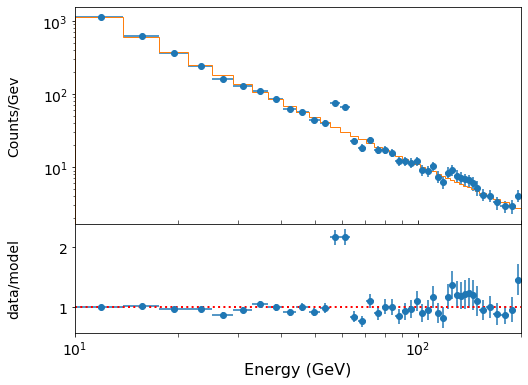

In [10]:
print("Background model for first dataset.")
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

As we can see from the plot the fit of the background follows exacly the background. For the most part the data/model ratio is 1 which prooves that indeed the model for the background is quite successful. We can also see that the data/model ratio is about 2 around the area of 60 GeV so we are going to search if there is an emeition line over there. Also we can observe a fluctuation in the data model ratio above the energy 90 GeV. But we can see that the errors in the measurments barely touch the data model ratio equals 1 line so the probably are radnom fluctuation during our measurment. Also the width of this feature is quite large so most likely it is not an emission line but we are going to test for it in order to be sure. Now we are going to add a Gaussian profile to our model and  do the fitting again in order to calculate the significance of this emission line. Firstly we are introducing the new model which we are going to use for our fitting.

In [11]:
def gaussian_model(x,parm):
    g_norm=parm[0]#normalisation factor of continuum
    g_gamma=parm[1]#power law index of continuum
    g_gnorm=parm[2]#normalisation of Gaussian
    g_sigma=2#Gaussian width fixed parameter due to our instruments energy resolution.
    g_ecent=parm[3]#Gaussian centroid
    g_flux = np.exp(-0.5*((x - g_ecent)/g_sigma)**2)/(g_sigma*np.sqrt(2.*np.pi))
    return g_norm*(x**(g_gamma))+g_gnorm*g_flux+0.4

In [12]:
model = gaussian_model
p0 = [20000,-2,300,60]  # Initial  parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("\nNormalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
print("Normalisation of Gaussian= "+str(ml_cfpars[2])+" +/- "+str(err[2]))
print("Gaussian centroid(in GeV)="+str(ml_cfpars[3])+" +/- "+str(err[3]))
minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

Covariance matrix: 
  [[ 1.59196323e+08 -1.90423474e+02  5.10563484e+04  9.76735256e+00]
 [-1.90423474e+02  2.37488063e-04 -7.24328522e-02 -8.65590492e-06]
 [ 5.10563484e+04 -7.24328522e-02  7.35017301e+02 -1.30432103e-01]
 [ 9.76735256e+00 -8.65590492e-06 -1.30432103e-01  5.14009324e-02]]

Normalisation at 1 GeV = 266091.2053806636 +/- 12617.30253735165
Power-law index = -2.2170241282392484 +/- 0.015410647725008568
Normalisation of Gaussian= 319.7902494580344 +/- 27.111202492624734
Gaussian centroid(in GeV)=59.16141153097004 +/- 0.22671773722583857
Minimum Chi-squared = 45.06354178222145 for 39 d.o.f.
The goodness of fit is: 0.23314095927777004


First dataset spectrum with 1 centroid.


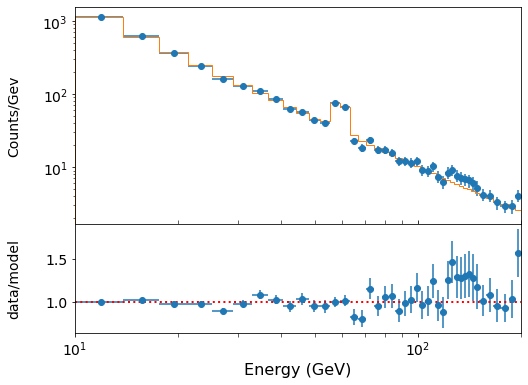

In [13]:
print("First dataset spectrum with 1 centroid.")
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

The fit comes out singificantly better this time. But we can see that there may be another emission line about 140 GeV. Before we introduce a new model firstly we are going to estimate the significance for the emission line on 59.48 GeV. We are going to do that using the Wilks theorem. Because we are measuring for a line we didn't now it existed we can use the Bonferroni correction.

In [14]:
print("p-value for our delta-chi-squared: ",sps.chi2.sf(157,df=1))
x=0
n=20
theta=sps.chi2.sf(157,df=1)
a=sps.binom.pmf(x,n,p=theta)
print("After bonferroni correction the p value is",1-a)
print("Because the original p value is realy small and we get into numerical trouble we will calculate it a bit different. \nAfter the Bofferoni correction the p-value is", 1-(1-20*theta))

p-value for our delta-chi-squared:  5.1185850322730644e-36
After bonferroni correction the p value is 0.0
Because the original p value is realy small and we get into numerical trouble we will calculate it a bit different. 
After the Bofferoni correction the p-value is 0.0


We can see that the signifigance is great so this feature is most likely an emission line now in order to get an even better fit and to test if the the feature at 140 GeV is significant or not we are going to introduce a model with two gaussians.

In [15]:
def gaussian_model2(x,parm):
    g_norm=parm[0]#normalisation factor of continuum
    g_gamma=parm[1]#power law index of continuum
    g_gnorm=parm[2]#normalisation of Gaussian
    g_sigma=2#Gaussian width fixed parameter due to our instruments energy resolution.
    g_ecent=parm[3]#Centroid of the first Gaussian
    g_gnorm2=parm[4]#Normalisation factor of the second Gaussian 
    g_ecent2=parm[5]#Centroid of the second Gaussian
    g_flux1 = np.exp(-0.5*((x - g_ecent)/g_sigma)**2)/(g_sigma*np.sqrt(2.*np.pi))
    g_flux2 = np.exp(-0.5*((x - g_ecent2)/g_sigma)**2)/(g_sigma*np.sqrt(2.*np.pi))
    return  g_norm*(x**(g_gamma))+g_gnorm*g_flux1+g_gnorm2*g_flux2+0.4

In [16]:
model = gaussian_model2
p0 = [200000,-2,300,60,100,140]  # Initial  parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("Normalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
print("Normalisation of Gaussian= "+str(ml_cfpars[2])+" +/- "+str(err[2]))
print("Gaussian centroid(in GeV)="+str(ml_cfpars[3])+" +/- "+str(err[3]))
print("Normalisation of second Gaussuan= "+str(ml_cfpars[4])+" +/- "+str(err[4]))
print("Second Gaussian centroid ="+str(ml_cfpars[5])+" +/-"+str(err[5]))
minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

Covariance matrix: 
  [[ 1.62816207e+08 -1.93222848e+02  5.21169401e+04  9.47548641e+00
   1.38844047e+04 -7.27326982e+01]
 [-1.93222848e+02  2.38883555e-04 -7.29958808e-02 -8.26400769e-06
  -1.83600868e-02  9.88609994e-05]
 [ 5.21169401e+04 -7.29958808e-02  7.18515848e+02 -1.26902385e-01
   6.63582592e+00 -3.78840573e-02]
 [ 9.47548641e+00 -8.26400769e-06 -1.26902385e-01  4.97525331e-02
   2.21906991e-04 -3.27267384e-07]
 [ 1.38844047e+04 -1.83600868e-02  6.63582592e+00  2.21906991e-04
   6.60744786e+01 -3.40056487e-01]
 [-7.27326982e+01  9.88609994e-05 -3.78840573e-02 -3.27267384e-07
  -3.40056487e-01  2.57261087e+00]]
Normalisation at 1 GeV = 269082.20220317534 +/- 12759.945396483714
Power-law index = -2.220992988565621 +/- 0.015455858283487731
Normalisation of Gaussian= 321.22151876702316 +/- 26.805145927789354
Gaussian centroid(in GeV)=59.16146003463699 +/- 0.22305275852916087
Normalisation of second Gaussuan= 13.922391126993478 +/- 8.128620955523816
Second Gaussian centroid =139.

First dataset spectrum with two Gaussians.


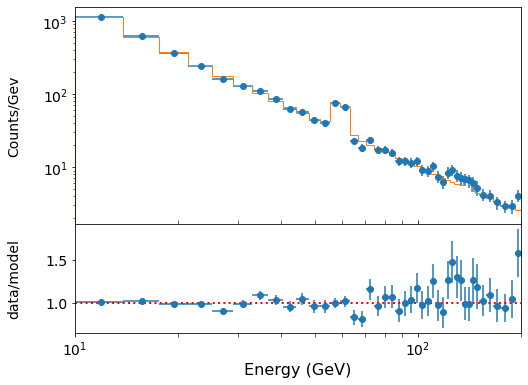

In [17]:
print("First dataset spectrum with two Gaussians.")
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

Although the goodness of the fit improved a bit, but still we can in confidence say that this is not a good fit.The impovment to the minimum chi squared form our previous fitting is about 4 and it is extremely small in order for this feature to be something important.Also the variation is very large for it to be an emition line. So as it was previously stated this probably is a measurment fluctuation that affects our fittings and it is the reason of the terible fittings we have been getting, but fortunately because it occurs in high energies so at least we can spot the emission line. The same problem occured and for the fourth dataset in which I have detailed explained what has happened.

Now we are going to search for emission lines in the next data sets using the same logic as we did for the first data set. So, to begin with the second data set we first have to rebin it.

In [18]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_2['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

Now we plot our second data set to get a first impression.

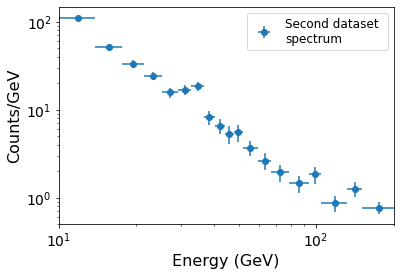

In [19]:
plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Second dataset \nspectrum')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               

Now we are going to fit the background with a simple power law model and use the data model ratio to search for possible emmision lines.

In [20]:
model = background_model
p0 = [200000,-1]  # Initial power-law parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("Normalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))

minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

Covariance matrix: 
  [[ 2.12709337e+07 -2.90185249e+02]
 [-2.90185249e+02  4.11780836e-03]]
Normalisation at 1 GeV = 23489.104705890142 +/- 4612.042243416143
Power-law index = -2.1956424271336457 +/- 0.06417015164869963
Minimum Chi-squared = 29.48851099268896 for 17 d.o.f.
The goodness of fit is: 0.03027856910581644


Comparing this fit to the last background fit, at this case it comes out much better. The goodness of the fit is much greater comparing to the previous case. Now we are going to plot our model in order to find possible features using the data model ratio.

Second dataset backgound fitted spectrum.


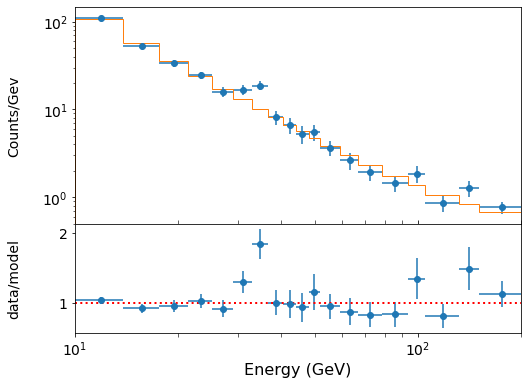

In [21]:
print("Second dataset backgound fitted spectrum.")
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

From the data model ratio we can see that there is a possible emission line on 35 GeV. Once again we can observe a lot of fluctuations in near the tail of the spectrum for which in this case we are not going to test for, for the reasons that were stated above. In sort the widht is very large for it to be an emission line and the counts are really low. Now we are going to add a gaussian at 35 GeV in order to find the significance.

In [22]:
model = gaussian_model
p0 = [200000,-2,300,35]  # Initial  parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("\nNormalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
print("Normalisation of Gaussian= "+str(ml_cfpars[2])+" +/- "+str(err[2]))
print("Gaussian centroid(in GeV)="+str(ml_cfpars[3])+" +/- "+str(err[3]))
minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

Covariance matrix: 
  [[ 1.21221568e+07 -1.51694997e+02  5.96913392e+03  2.07494470e+01]
 [-1.51694997e+02  1.97289194e-03 -9.81423456e-02 -6.09521294e-05]
 [ 5.96913392e+03 -9.81423456e-02  1.14334613e+02 -6.83441455e-01]
 [ 2.07494470e+01 -6.09521294e-05 -6.83441455e-01  2.99522930e-01]]

Normalisation at 1 GeV = 26146.242957482864 +/- 3481.68879186562
Power-law index = -2.241666438670602 +/- 0.0444172482593453
Normalisation of Gaussian= 55.38228655345138 +/- 10.692736455466706
Gaussian centroid(in GeV)=33.67848873146679 +/- 0.5472868805597354
Minimum Chi-squared = 10.482159271218327 for 15 d.o.f.
The goodness of fit is: 0.7883656551130596


We got 78% goodness of fit which is very impressive and we can say that this is a good fit.Now we are going to plot our fit.

Second dataset spectrum Gaussian fitted.


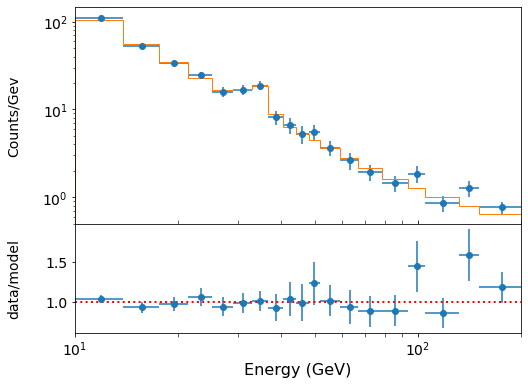

In [23]:
print("Second dataset spectrum Gaussian fitted.")
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

We have an improvement to the chi square of 19. So we have that $\Delta\chi^{2}=19$ the degrees of freedom in this case are 1 because the energy of the centroid which is theother parameter is not really a nestable parameter. So using Wilks theorem with the Bonferroni correction(because we didn't know before hand the existance of the line) we are going to calculate the significanceof this  line.

In [24]:
print("p-value for our delta-chi-squared: ",sps.chi2.sf(19,df=1))
x=0
n=20
theta=sps.chi2.sf(19,df=1)
a=sps.binom.pmf(x,n,p=theta)
print("After bonferroni correction the p value is",1-a)

p-value for our delta-chi-squared:  1.3071845366762988e-05
After bonferroni correction the p value is 0.00026140444398548013


After the Bofferoni correction the significance comes at $3\sigma$ which means it is just significant enough. As before it seems like they may be some possible features at higher energies but the data model ratio for them is smaller than the one in the  emission line we just calculated. Also, as mentioned earlier their widths are rather large for them to be emission line, because at theory  the emissions lines suppose to have zero width, so in our case the width of the instrument's resolution. So for these two reasons we are not going to search for emission lines in that area.

Now we are continuing with the third dataset once again firstly we have to rebin the data.

In [25]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_3['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

Now we are going to plot the dataset3 to get a first impresion.

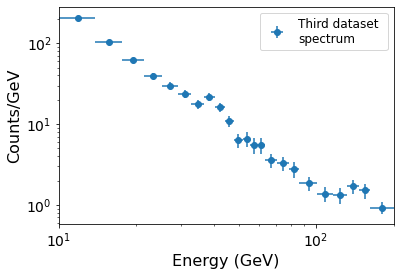

In [26]:
plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Third dataset \nspectrum')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               

We can see that there may be a feature at 40 GeV and at this time we may need to test for a pick at the higher energies as well. So firstly we do the background fitting with a simple power law and then using the data model ratio we will search for possible emission lines.

In [27]:
model = background_model
p0 = [200000,-1]  # Initial power-law parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("Normalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))

minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

Covariance matrix: 
  [[ 5.07673548e+07 -3.03952836e+02]
 [-3.03952836e+02  1.89228134e-03]]
Normalisation at 1 GeV = 53734.40723923978 +/- 7125.121387621891
Power-law index = -2.269288354032596 +/- 0.043500360186931944
Minimum Chi-squared = 30.6784147849833 for 21 d.o.f.
The goodness of fit is: 0.07917905698371074


The fit doesn't come out the best possible as we can see from the goodness of the fit parameter but we expected it to not be perfect because we have not added any Gaussian profiles.

Third dataset backgound fitted spectrum.


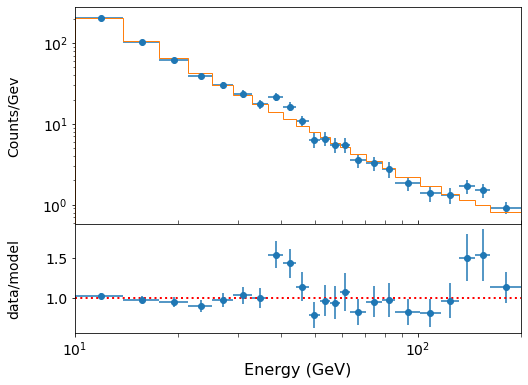

In [28]:
print("Third dataset backgound fitted spectrum.")
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

It seems like there are two possible emissions one at 40 GeV and one  at 150 GeV. First we are going to test for the one at 40 GeV.

In [29]:
model = gaussian_model
p0 = [200000,-2,300,40]  # Initial  parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("\nNormalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
print("Normalisation of Gaussian= "+str(ml_cfpars[2])+" +/- "+str(err[2]))
print("Gaussian centroid(in GeV)="+str(ml_cfpars[3])+" +/- "+str(err[3]))
minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

Covariance matrix: 
  [[ 3.26100875e+07 -1.81923847e+02  1.19083725e+04  3.44277728e+01]
 [-1.81923847e+02  1.05374780e-03 -8.14213818e-02 -1.53182737e-04]
 [ 1.19083725e+04 -8.14213818e-02  1.26087588e+02 -2.64394956e-01]
 [ 3.44277728e+01 -1.53182737e-04 -2.64394956e-01  2.96608672e-01]]

Normalisation at 1 GeV = 58701.89220989135 +/- 5710.524278123037
Power-law index = -2.3046890044395516 +/- 0.03246148181533663
Normalisation of Gaussian= 55.3573457020433 +/- 11.228872973112818
Gaussian centroid(in GeV)=39.9017306612644 +/- 0.544617913554737
Minimum Chi-squared = 13.45317754070024 for 19 d.o.f.
The goodness of fit is: 0.8145852080633754


The fit now is rather good. The goodness of the fit parameter has gone up to 81% which is really high. Now we are going to plot our fit.

Third dataset spectrum Gaussian fitted.


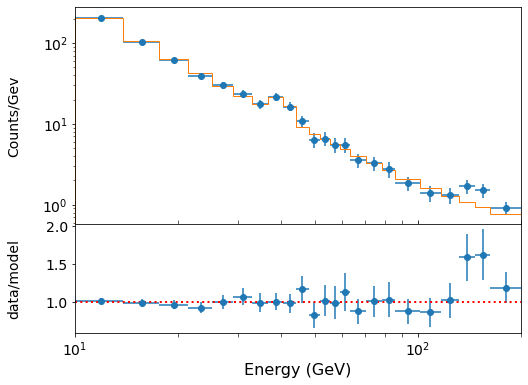

In [30]:

print("Third dataset spectrum Gaussian fitted.")
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

We can see now that data model ratio for the possible feature at 150 GeV has dropped. We can also see that the difference in chi square between the two fittings is 17,2. Using this difference and considering one degree of freedom as it was explained earlier we are going to calculate the significance of this line using the Wilk's theorem with the addition of the Boferroni correction. So we have that

In [31]:
print("p-value for our delta-chi-squared: ",sps.chi2.sf(17.2,df=1))
x=0
n=20
theta=sps.chi2.sf(17.2,df=1)
a=sps.binom.pmf(x,n,p=theta)
print("After bonferroni correction the p value is",1-a)

p-value for our delta-chi-squared:  3.364363536121403e-05
After bonferroni correction the p value is 0.0006726576907317705


Once again the significance after the Boferroni correction comes out around $3\sigma$ so it means that this lines is an emission line. Now we are going to add a second Gaussian to test for the feature at 150 GeV. So first we are going to fit oyr data with the model that consists of two Gaussian profiles.

In [32]:
model = gaussian_model2
p0 = [200000,-2,300,40,100,150]  # Initial  parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("Normalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
print("Normalisation of Gaussian= "+str(ml_cfpars[2])+" +/- "+str(err[2]))
print("Gaussian centroid(in GeV)="+str(ml_cfpars[3])+" +/- "+str(err[3]))
print("Normalisation of second Gaussuan= "+str(ml_cfpars[4])+" +/- "+str(err[4]))
print("Second Gaussian centroid ="+str(ml_cfpars[5])+" +/-"+str(err[5]))
minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

Covariance matrix: 
  [[ 2.02334257e+07 -1.07003829e+02  7.17826046e+03  1.72668214e+01
   3.65217284e+03 -2.26147714e+01]
 [-1.07003829e+02  5.86236686e-04 -4.56564688e-02 -7.13357825e-05
  -2.10841928e-02  1.34216707e-04]
 [ 7.17826046e+03 -4.56564688e-02  6.46060378e+01 -1.31050275e-01
   1.96484911e+00 -1.35506220e-02]
 [ 1.72668214e+01 -7.13357825e-05 -1.31050275e-01  1.40328759e-01
   1.37917362e-03 -4.94638429e-06]
 [ 3.65217284e+03 -2.10841928e-02  1.96484911e+00  1.37917362e-03
   1.85119884e+01 -3.95265717e-02]
 [-2.26147714e+01  1.34216707e-04 -1.35506220e-02 -4.94638429e-06
  -3.95265717e-02  2.96288645e-01]]
Normalisation at 1 GeV = 62512.83374350601 +/- 4498.158032574001
Power-law index = -2.3273222768609205 +/- 0.024212325081936516
Normalisation of Gaussian= 57.46904421041852 +/- 8.037788113165313
Gaussian centroid(in GeV)=39.90355995106807 +/- 0.37460480413424696
Normalisation of second Gaussuan= 19.37312893363003 +/- 4.302556031368651
Second Gaussian centroid =146.6838

Although the goodness of the fit has improved to the almost absolute perfect the chi square has dropped only about 6,3 which is very little and as it can been seen from the calculations bellow
the p-value comes out quite large so  the significance is low so this line is not an emission line.

In [33]:
print("p-value for our delta-chi-squared: ",sps.chi2.sf(6.3,df=1))
x=0
n=20
theta=sps.chi2.sf(6.3,df=1)
a=sps.binom.pmf(x,n,p=theta)
print("After bonferroni correction the p value is",1-a)

p-value for our delta-chi-squared:  0.0120737972431229
After bonferroni correction the p value is 0.21568578289187557


Now we are going to analyse the spectrum of the the fourth dataset. We start by rebbining the data.

In [34]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_4['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

Now we are going to plot the spectrum just to get a first idea.

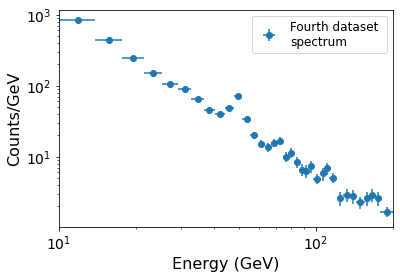

In [35]:
plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Fourth dataset \nspectrum')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               

There seems to be a emission line around 50 GeV. We are goind to fit the background of the model with a simple power law and then use the data model ratio to find possible features

In [36]:
model = background_model
p0 = [200000,-1]  # Initial power-law parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("Normalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))

minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

Covariance matrix: 
  [[ 1.01231448e+09 -1.26571311e+03]
 [-1.26571311e+03  1.64702757e-03]]
Normalisation at 1 GeV = 257357.0809109222 +/- 31816.88978973663
Power-law index = -2.331655895161686 +/- 0.04058358740738207
Minimum Chi-squared = 173.18728125852004 for 33 d.o.f.
The goodness of fit is: 6.210033894503759e-21


The goodness of the fit parameter comes out really small. We are going to plot our fit and find an explanation of why this happens.In both dataset 1 and 4 we have the same problem I have tried the power law, the power law with cut off, the expontial plus the power law, the curved power law model, and the truth is I am getting the best fit possible for the power law and this is highly logical because the continuum spectrum is linear only in the log-log scale so everything suggests the power law model is the way to go. But the problem with getting such terrible fits is that we can not calculate the significance well because the chi square difference is huge after we add the Gaussian profile to the fit and obviously I get huge significances which I do not know how truthful they are. Also, I should add that at both cases the error bars of the measurments 'touch' the data model ratio equals one line, so maybe the terrible fit that I get has to to do with statistical flactuations or it has to do with how the instrment would cope to low redshifts or higher energies. In our analysis in task 4 when we plot the spectrum for the time period 0-20 seconds we get much better fittings so the explanation of our terible fits may be that in the  second half that there is too much noise in our measurments in the second half of the burst(20-40 seconds).

Fourth dataset spectrum continuum fitted.


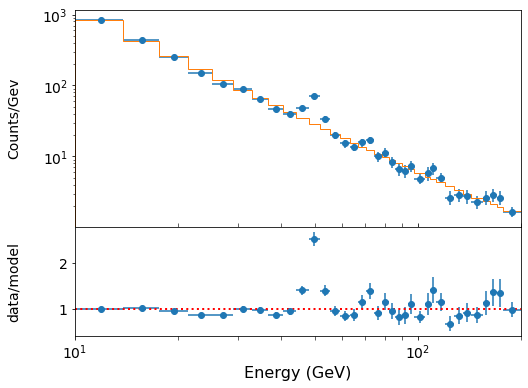

In [37]:
print("Fourth dataset spectrum continuum fitted.")
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

Firstly, we can see a possible feature at 50 GeV. As it happened for the first data set which is also for a smaller redshift compared to the other datasets we can see a lot of fluctuations at high energies which messes up our fittings. In lower redshifts we except higher energies and both of the first and fourth dataset are for lower redshifts. So it is quite possible that there may be an issue with the sensitivity of our instrument an these high energies and that is why we get this fluctuations. So we can add to our conclusions that it is quite possible for this instrument to work better at lower energies or higher red shifts. We continue to test for the significance at 50 GeV by adding a Gaussian profile to our model.

In [38]:
model = gaussian_model
p0 = [200000,-2,300,50]  # Initial  parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("\nNormalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
print("Normalisation of Gaussian= "+str(ml_cfpars[2])+" +/- "+str(err[2]))
print("Gaussian centroid(in GeV)="+str(ml_cfpars[3])+" +/- "+str(err[3]))
minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

Covariance matrix: 
  [[ 3.55954699e+08 -4.06711305e+02  8.45285727e+04 -2.87641928e+01]
 [-4.06711305e+02  4.82530961e-04 -1.13817819e-01  5.53792275e-05]
 [ 8.45285727e+04 -1.13817819e-01  7.35933518e+02 -5.49115182e-01]
 [-2.87641928e+01  5.53792275e-05 -5.49115182e-01  9.48991612e-02]]

Normalisation at 1 GeV = 286321.8957987632 +/- 18866.761750984264
Power-law index = -2.3726463205545008 +/- 0.021966587370643526
Normalisation of Gaussian= 267.67800514313325 +/- 27.12809462783931
Gaussian centroid(in GeV)=49.63421025630621 +/- 0.30805707455792963
Minimum Chi-squared = 41.71347395039802 for 31 d.o.f.
The goodness of fit is: 0.09475347444914779


The goodness of the fit has improved dramatically but it is still very low. Chi square difference is very large the significance will be very large.Firstly we will plot our fitted model. 

Fourth dataset spectrum Gaussian fitted.


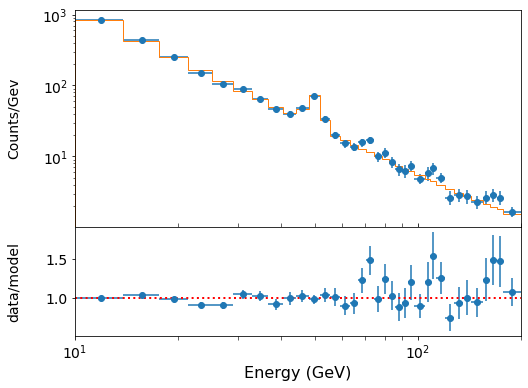

In [39]:
print("Fourth dataset spectrum Gaussian fitted.")
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

In order to calculate the significance we are going to use Wilk's theorem with the Boferroni correction. In this case we have that $\Delta\chi^{2}=132$ and the degrees of freedom are $\nu=1$ for the reasons we explained earlier. So as it can been seen from the calculations bellow the significance is huge but this number is not completely true because the fitting of the continuum spectrum is not so successful. (The same applies for the first data set) 

In [40]:
print("p-value for our delta-chi-squared: ",sps.chi2.sf(132,df=1))
x=0
n=20
theta=sps.chi2.sf(132,df=1)
a=sps.binom.pmf(x,n,p=theta)
print("After bonferroni correction the p value is",1-a)

p-value for our delta-chi-squared:  1.4961918421611556e-30
After bonferroni correction the p value is 0.0


## Task 2

In this task we are going to determine more percise redshifts. We are going to do this by calculating the fitting the spectrum for the photon's rest frame by using the formula $E=E_{0}(z+1)^{-1}$. Basically we are going to replace the centroid energy with $E_{0}(z+1)^{-1}$ so we are taking out one free parameter and we are putting in two others so firstly w eneed to define tne new Gaussian profile.

In [41]:
#Model for redshift with all the parameters frozen in order to use it for the second dataset.
def redshift_gaussian(x,parm):
    r_norm=parm[0]#normalisation factor of continuum
    r_gamma=parm[1]#power law index of continuum
    r_gnorm=parm[2]#normalisation of Gaussian
    r_sigma=2#Gaussian width fixed parameter due to our instruments energy resolution.
    r_zet=parm[3]#Redshift
    r_energy=parm[4]
    #r_centroid=r_energy/(r_zet+1)
    r_flux =np.exp(-0.5*(((x*r_zet+x-r_energy) /((r_zet+1)*r_sigma))**2))/(r_sigma*np.sqrt(2.*np.pi))
    return r_norm*(x**(r_gamma))+r_gnorm*r_flux+0.4
    

Before we continue we need to define three more functions which are going to help us calculate the upper and lower limit on the redshift.(These functions were taken from the lecture notes exept the last one in which we did some minor changes.)

In [42]:
def grid1d_chisqmin_cfint(a_index,a_range,a_steps,parm,model,xval,yval,dy,xedges):
    '''Finds best the fit and then carries out chisq minimisation for a 1D grid of fixed parameters.
       Input: 
            a_index - index of 'a' parameter (in input list parm) to use for grid.
            a_range, a_steps - range (tuple or list) and number of steps for grid.
            parm - parameter list for model to be fitted.
            model - name of model function to be fitted.
            xval, dyval, dy - data x, y and y-error arrays
        Output: 
            a_best - best-fitting value for 'a'
            minchisq - minimum chi-squared (for a_best)
            a_grid - grid of 'a' values used to obtain fits
            chisq_grid - grid of chi-squared values corresponding to a_grid'''
    a_grid = np.linspace(a_range[0],a_range[1],a_steps)
    chisq_grid = np.zeros(len(a_grid))
    # First obtain best-fitting value for 'a' and corresponding chi-squared
    ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda xval, *parm: model_int_cf(xval, xedges, 
                            model, parm), xval, yval, parm, sigma=dy)
    
    minchisq = np.sum(((yval-model_int_cf(xval,xedges,model,*ml_cfpars))/dy)**2)
    a_best = ml_cfpars[a_index]
    print("The minimum chi square is: ",minchisq,"and the redshift is: ",a_best)
    # Now remove 'a' from the input parameter list, so this parameter may be frozen at the 
    # grid value for each fit
    free_parm = np.delete(parm,a_index)
    # Now fit for each 'a' in the grid, to do so we must use a lambda function to insert the fixed 
    # 'a' into the model function when it is called by curve_fit, so that curve_fit does not use 
    # 'a' as one of the free parameters so it remains at the fixed grid value in the fit.
    for i, a_val in enumerate(a_grid):        
        ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda xval, *parm: model_int_cf(xval, xedges, 
                            model, parm), xval, yval, parm, sigma=dy)        
        chisq_grid[i] = np.sum(((yval-model_int_cf(xval,xedges,model,
                                                   *np.insert(ml_cfpars,a_index,a_val)))/dy)**2)
        #print(i+1,'steps: chisq =',chisq_grid[i],'for a =',a_val,' minimum = ',minchisq,' for a =',a_best)
    return a_best, minchisq, a_grid, chisq_grid  

    
def calc_upper_chisq(delchisq,minchisq,a_grid,chisq_grid):
    '''Function to return upper values of a parameter 'a' for a given delta-chi-squared
       Input:
           delchisq - the delta-chi-squared for the confidence interval required (e.g. 1 for 1-sigma error)
           a_grid, chisq_grid - grid of 'a' and corresponding chi-squared values used for interpolation'''
    # First interpolate over the grid for values > a_best and find upper interval bound
    chisq_interp_upper = spinterp.interp1d(chisq_grid,a_grid)
    a_upper = chisq_interp_upper(minchisq+delchisq)
    return a_upper


def calc_error_chisq(delchisq,a_best,minchisq,a_grid,chisq_grid):
    '''Function to return upper and lower values of a parameter 'a' for a given delta-chi-squared
       Input:
           delchisq - the delta-chi-squared for the confidence interval required (e.g. 1 for 1-sigma error)
           a_best, minchisq - best-fitting value for 'a' and corresponding chi-squared minimum
           a_grid, chisq_grid - grid of 'a' and corresponding chi-squared values used for interpolation'''
    # First interpolate over the grid for values > a_best and find upper interval bound
    chisq_interp_upper = spinterp.interp1d(chisq_grid[a_grid > a_best],a_grid[a_grid > a_best])
    a_upper = chisq_interp_upper(minchisq+delchisq)
    # Interpolate for values <= a_best to find lower interval bound
    chisq_interp_lower = spinterp.interp1d(chisq_grid[a_grid <= a_best],a_grid[a_grid <= a_best])
    a_lower = chisq_interp_lower(minchisq+delchisq)  
    return [a_lower,a_upper]

Now we are going to firstly calculate the redshift of dataset number 2 by fitting the spectrum of the second dataset with our new model.

In [43]:
emin, emax = 10., 200.#We rebin the data just to make sure the cdens values and energies are refering
nbins = 50            #to the correct dataset.
counts, edges = np.histogram(data_2['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

In [44]:
model = redshift_gaussian
p0 = [26146,-2.24,55.38,2,99]
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))

minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

Minimum Chi-squared = 10.48215926860221 for 14 d.o.f.
The goodness of fit is: 0.7261512670529655


The goodness of the fit is rather good but most important is to see how good the fit covers the area of the emission line and as we can see bellow it does that quite well.

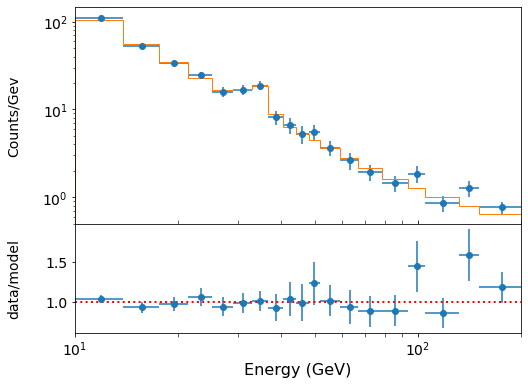

In [45]:
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

Now we are going to use the functions  grid1d_chisqmin_cfint, calc_upper_chisq in order to calculate the upper and lower limits of  the redshift. We freeze the parameter for the rest frame energy at 99 GeV because the centroid is at 33 GeV so using the formula for redshift 2 we obtain rest frame energy of 99 GeV.

The minimum chi square is:  10.482159268715941 and the redshift is:  1.939565123208918
3-sigma upper limit on the redshift:  2.108122484092642


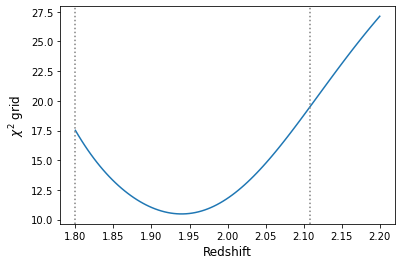

In [46]:
fixed_en = 99


new_model = lambda x, parm: redshift_gaussian(x,np.insert(parm,4,fixed_en))


parm = [26146.24,-2.24,55.38,2]
a_index = 3
par_range=[1.8,2.2]
n_steps=100
#Now we run the grid calculation
a_best, minchisq, a_grid, chisq_grid = grid1d_chisqmin_cfint(a_index,par_range,n_steps,parm,new_model,
                             energies,cdens,cdens_err,edges2)

delchisq = 9
a_upper = calc_upper_chisq(delchisq,minchisq,a_grid,chisq_grid)

print("3-sigma upper limit on the redshift: ", a_upper)

plt.figure()
plt.plot(a_grid,chisq_grid)
plt.xlabel(r'Redshift',fontsize=12)
plt.ylabel(r'$\chi^{2}$ grid',fontsize=12)
#we plot the limits of our new interval.
plt.axvline(a_upper,c='gray',linestyle='dotted')
plt.axvline(1.8,c='gray',linestyle='dotted')

plt.show()

We have found a new 3 sigma upper limit at 1.96. So the new range for the redshift is 1.8<z<1.96 and according to our fit the redshift is 1.93.The new range can been seen on the $\chi^2$ grid-Redshift plot.

Now we are going to do the same analysis for the third data set. First we rebim the dataset just to be sure we are using the correct variables.

In [47]:
emin, emax = 10., 200.#We rebin the data just to make sure the cdens values and energies are refering
nbins = 50            #to the correct dataset.
counts, edges = np.histogram(data_3['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

Minimum Chi-squared = 13.453177540700457 for 18 d.o.f.
The goodness of fit is: 0.7639790512908855


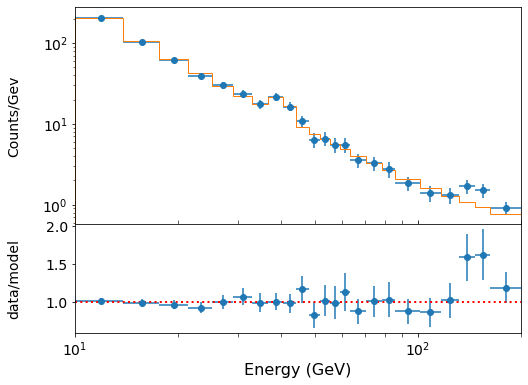

In [48]:
model = redshift_gaussian
p0 = [58701.89,-2.3,55.34,1.4,95.76]#initial values for the fit.
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))

minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)
print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

As we can see above the goodness of the fit comes out really good and we can see from the plot with the data and the fitted model that the fitting is succesful. Now we are going to freeze the parameter for the rest frame energy at 95.76, following the same logic with the last case, but this time the range of the redshift is different so we calculated this rest frame energy considering that the redshift is about 1.4. And then using the calc_error_chisq function we calculate the new range for the redshift.

The minimum chi square is:  13.453177540784191 and the redshift is:  1.399895935755762


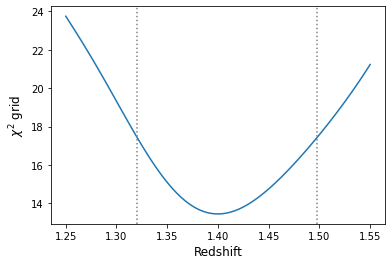

In [49]:
fixed_en = 95.76


new_model = lambda x, parm: redshift_gaussian(x,np.insert(parm,4,fixed_en))


parm = [58701.89,-2.3,55.35,1.4]
a_index = 3
par_range=[1.25,1.55]
n_steps=100
#Now we run the grid calculation
a_best, minchisq, a_grid, chisq_grid = grid1d_chisqmin_cfint(a_index,par_range,n_steps,parm,new_model,
                             energies,cdens,cdens_err,edges2)

delchisq = 4#for 2-sigma confidence interval
a_upper,a_lower=calc_error_chisq(delchisq,a_best,minchisq,a_grid,chisq_grid)

plt.figure()
plt.plot(a_grid,chisq_grid)
plt.xlabel(r'Redshift',fontsize=12)
plt.ylabel(r'$\chi^{2}$ grid',fontsize=12)
#we plot the limits of our new interval.
plt.axvline(a_upper,c='gray',linestyle='dotted')
plt.axvline(a_lower,c='gray',linestyle='dotted')

plt.show()

So for the third dataset the best value for the redshift is 1.399 and the 2$\sigma$ confidence interval for the redshift is 1.32<z<1.49 as it can been seen from the $\chi^2$ grid-redshift plot above.

Now we are going to do the same analysis for the fourth dataset. Once again we start by rebining the data just to be sure we are refering to the correct variables into the following steps.

In [50]:
emin, emax = 10., 200.#We rebin the data just to make sure the cdens values and energies are refering
nbins = 50            #to the correct dataset.
counts, edges = np.histogram(data_4['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

Minimum Chi-squared = 41.713473950275734 for 30 d.o.f.
The goodness of fit is: 0.0757134856823294


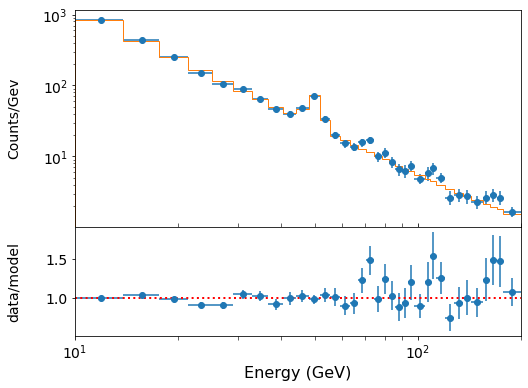

In [51]:
model = redshift_gaussian
p0 = [286321,-2.37,49.63,1,99.26]#initial values for the fit.
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))

minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)
print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

As it happened before the goodness of the fit for the forth dataset doesn't come out great. But in any case because the calc_error_chisq function works with the $\chi^2$ values of the grid we will be able to calculate the confidence interval. Making the same considerations as we did before fixing the rest frame energy at 99.26 GeV by considering that the redshift is about 1.

The minimum chi square is:  41.71347395437683 and the redshift is:  0.9998297447711555


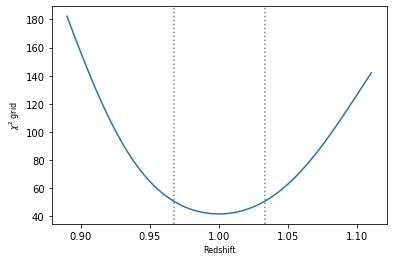

In [52]:
fixed_en = 99.26


new_model = lambda x, parm: redshift_gaussian(x,np.insert(parm,4,fixed_en))


parm = [286321.8957,-2.37,49.63,1]
a_index = 3
par_range=[0.89,1.11]
n_steps=100
#Now we run the grid calculation
a_best, minchisq, a_grid, chisq_grid = grid1d_chisqmin_cfint(a_index,par_range,n_steps,parm,new_model,
                             energies,cdens,cdens_err,edges2)

delchisq = 9#for 3-sigma confidence interval
a_upper,a_lower=calc_error_chisq(delchisq,a_best,minchisq,a_grid,chisq_grid)

plt.figure()
plt.plot(a_grid,chisq_grid)
plt.xlabel(r'Redshift',fontsize=8)
plt.ylabel(r'$\chi^{2}$ grid',fontsize=8)
#we plot the limits of our new interval.
plt.axvline(a_upper,c='gray',linestyle='dotted')
plt.axvline(a_lower,c='gray',linestyle='dotted')

plt.show()

From the plot above we can see that the 3-sigma confidence interval is 0.97<z<1.2.

## Task 3:

In [53]:
times=[data_1['Time'],data_2['Time'],data_3['Time'],data_4['Time']]

Firstly we are going to make the histograms of our datasets to get a first picture of our bursts profiles.

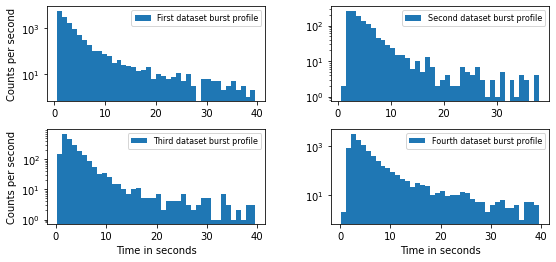

In [54]:

fig, ax = plt.subplots(2,2, figsize=(9,4))
fig.subplots_adjust(wspace=0.3,hspace=0.3)
ax[0,0].hist(times[0],bins=40,label="First dataset burst profile",log=True)
ax[0,1].hist(times[1],bins=40,label="Second dataset burst profile",log=True)
ax[1,0].hist(times[2],bins=40,label="Third dataset burst profile",log=True)
ax[1,1].hist(times[3],bins=40,label="Fourth dataset burst profile",log=True)
for i in range(2):
    for j in range(2):
        ax[i,j].legend(fontsize=8)
        
        if j==0:
            ax[i,j].set_ylabel('Counts per second')
        if i==1:
            ax[i,j].set_xlabel('Time in seconds')
plt.show()



Now we are going to use the histograms and create the scatter plots on which we can apply model fitting.

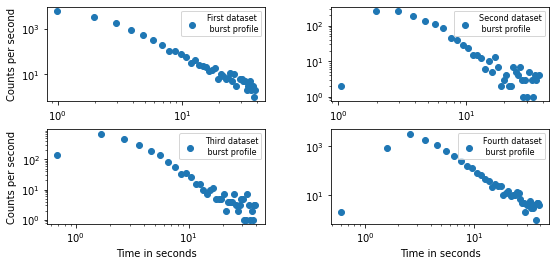

In [55]:
x=40 #we have choosen 40 bins in order to obtain the counts in counts per second.
fig, ax = plt.subplots(2,2, figsize=(9,4))
fig.subplots_adjust(wspace=0.3,hspace=0.3)
tc1,tedg1=np.histogram(times[0],bins=x)
tc2,tedg2=np.histogram(times[1],bins=x)
tc3,tedg3=np.histogram(times[2],bins=x)
tc4,tedg4=np.histogram(times[3],bins=x)
ax[0,0].scatter((tedg1[:-1]+tedg1[1:])/2,tc1,label="First dataset\n burst profile")
ax[0,1].scatter((tedg2[:-1]+tedg2[1:])/2,tc2,label="Second dataset\n burst profile")
ax[1,0].scatter((tedg3[:-1]+tedg3[1:])/2,tc3,label="Third dataset\n burst profile")
ax[1,1].scatter((tedg4[:-1]+tedg4[1:])/2,tc4,label="Fourth dataset\n burst profile")
for i in range(2):
    for j in range(2):
        ax[i,j].legend(fontsize=8,loc=1)
        ax[i,j].set_yscale('log')
        ax[i,j].set_xscale('log')
        if j==0:
            ax[i,j].set_ylabel('Counts per second')
        if i==1:
            ax[i,j].set_xlabel('Time in seconds')
plt.show()

At first we can make some observation about the plots. All the plots have the wanted shape and the shape tha we expected. We can also see that in the second and the third dataset which refer to higher redshifts or measuring smaller energies, we get higher counts per second from those we get from the first and fourth datasets. The first and fourth dataset refer to lower redshifts so the measuring energy is greater compared to the other two datasets and we can see because the measuring energy is higher the background does not affect the burst profile that much as it does the other two datasets. This can been seen in the tail of each plot. The tails of the first and fourth busrt profiles are a lot smoother than the tails of the third and second profile. Bellow we are defining a function that calculates the negative Poisson log-likelihood which we are going to use in comibination with spopt.minimize to obtain the best fit possible for our busrt profiles. 

In [56]:
def LogLikelihood_Pois_Integ(parm, model, ebins, counts): 
    '''Calculate the negative Poisson log-likelihood for a model integrated over bins. 
       Inputs:
           parm - model parameter list.
           model - model function name.
           ebins, counts - energy bin edges and corresponding counts per bin.
        Outputs: the negative Poisson log-likelihood'''
    i = 0
    ymod = np.zeros(len(counts))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, parm),ebins[i],ebins[i+1])
        # we don't normalise by bin width since the rate parameter is set by the model and needs to be 
        # in counts per bin
        i=i+1        
    pd = sps.poisson(ymod) #we define our Poisson distribution
    return -sum(pd.logpmf(counts))


We also define this power law model with an extra parameter which is the start time of the burst because in our plots above we can see that most of them do not start immediately so we are using this parameter to find out in where the burst starts.

In [57]:
def pl_model(x,parm):
    pl_norm=parm[0]#Normalisation factor
    pl_index=parm[1]#Power law index
    pl_start=parm[2]#Start time of the burst
    return pl_norm*(x+pl_start)**pl_index+0.4

Now we are doing the fitting for the first dataset.

In [58]:
parm = [2500.0, -1.5]
result = spopt.minimize(LogLikelihood_Pois_Integ, parm, args=(background_model, tedg1, tc1), method='BFGS')
err = np.sqrt(np.diag(result.hess_inv))
print("Covariance matrix:\n",result.hess_inv)
print("Normalisation at 1 Second = " + str(result.x[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(result.x[1]) + " +/- " + str(err[1]))

print("Maximum log-likelihood = " + str(-1.0*result.fun))

Covariance matrix:
 [[6.23738029e-05 1.95786511e-05]
 [1.95786511e-05 1.04117701e-05]]
Normalisation at 1 Second = 5968.25130070229 +/- 0.007897708710669936
Power-law index = -1.6919279485223122 +/- 0.003226727462845875
Maximum log-likelihood = -1254.9072174930288


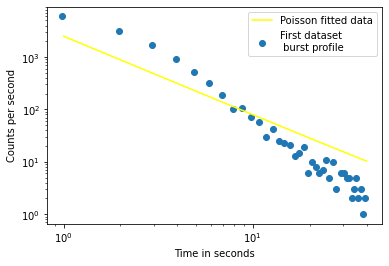

In [59]:
t=np.linspace(1,40,100)
result.x=parm
plt.figure()
plt.scatter((tedg1[:-1]+tedg1[1:])/2,tc1,label="First dataset\n burst profile")
plt.plot(t,background_model(t,parm),c='yellow',label="Poisson fitted data")
plt.legend(fontsize=10)
plt.xlabel('Time in seconds')
plt.ylabel('Counts per second')
plt.xscale('log')
plt.yscale('log')

Now we are doing the fitting for the second dataset.

In [60]:
parm = [2500.0,-1.5,2]
result = spopt.minimize(LogLikelihood_Pois_Integ, parm, args=(pl_model, tedg2, tc2), method='BFGS')
err = np.sqrt(np.diag(result.hess_inv))
print("Covariance matrix: \n",result.hess_inv)
print("Normalisation at 1 Second = " + str(result.x[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(result.x[1]) + " +/- " + str(err[1]))
print("Start time = " + str(result.x[2]) + " +/- " + str(err[2]))
print("Maximum log-likelihood = " + str(-1.0*result.fun))

Covariance matrix: 
 [[5.30664232e+06 4.04723364e-01 1.63982798e+02]
 [4.04723364e-01 5.75468226e-04 5.20554082e-03]
 [1.63982798e+02 5.20554082e-03 5.77117077e-02]]
Normalisation at 1 Second = 295261.029663695 +/- 2303.6150546747585
Power-law index = -3.0987946157616304 +/- 0.023988918825284204
Start time = 8.580241743134165 +/- 0.24023261154700692
Maximum log-likelihood = -454.89281417080986


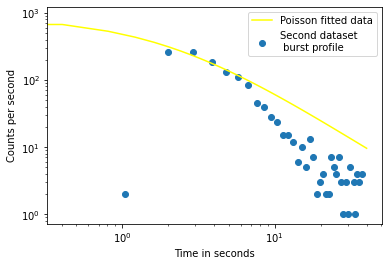

In [61]:
t=np.linspace(0,40,100)
result.x=parm
plt.figure()
plt.scatter((tedg2[:-1]+tedg2[1:])/2,tc2,label="Second dataset\n burst profile")
plt.plot(t,pl_model(t,parm),c='yellow',label="Poisson fitted data")
plt.legend(fontsize=10)
plt.xlabel('Time in seconds')
plt.ylabel('Counts per second')
plt.xscale('log')
plt.yscale('log')

Now we are doing the fitting for the third dataset.

In [62]:
parm = [2500.0,-1.5,1]
result = spopt.minimize(LogLikelihood_Pois_Integ, parm, args=(pl_model, tedg3, tc3), method='BFGS')
err = np.sqrt(np.diag(result.hess_inv))
print("Covariance matrix: \n",result.hess_inv)
print("Normalisation at 1 Second = " + str(result.x[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(result.x[1]) + " +/- " + str(err[1]))
print("Start time = " + str(result.x[2]) + " +/- " + str(err[2]))
print("Maximum log-likelihood = " + str(-1.0*result.fun))

Covariance matrix: 
 [[ 3.59206896e+06 -1.79309105e+00  5.66318611e+00]
 [-1.79309105e+00  2.88256532e-04  1.83675094e-03]
 [ 5.66318611e+00  1.83675094e-03  1.44413742e-02]]
Normalisation at 1 Second = 447567.98365329474 +/- 1895.275431282176
Power-law index = -3.2678544037543893 +/- 0.01697811921129611
Start time = 6.880252904951217 +/- 0.12017226875575462
Maximum log-likelihood = -565.9827464755729


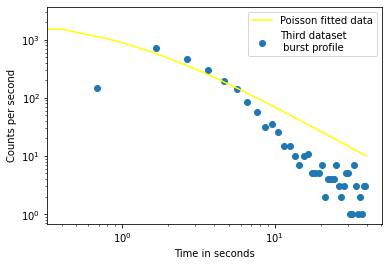

In [63]:
t=np.linspace(0,40,100)
result.x=parm
plt.figure()
plt.scatter((tedg3[:-1]+tedg3[1:])/2,tc3,label="Third dataset\n burst profile")
plt.plot(t,pl_model(t,parm),c='yellow',label="Poisson fitted data")
plt.legend(fontsize=10)
plt.xlabel('Time in seconds')
plt.ylabel('Counts per second')
plt.xscale('log')
plt.yscale('log')

Now we are doing the fitting for the fourth dataset.

In [64]:
parm = [2500.0,-1.5,1]
result = spopt.minimize(LogLikelihood_Pois_Integ, parm, args=(pl_model, tedg4, tc4), method='BFGS')
err = np.sqrt(np.diag(result.hess_inv))
print("Covariance matrix: \n",result.hess_inv)
print("Normalisation at 1 Second = " + str(result.x[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(result.x[1]) + " +/- " + str(err[1]))
print("Start time = " + str(result.x[2]) + " +/- " + str(err[2]))
print("Maximum log-likelihood = " + str(-1.0*result.fun))

Covariance matrix: 
 [[ 9.69242355e+08 -4.62031867e+02  4.04244657e+03]
 [-4.62031867e+02  2.70359460e-04 -1.56276248e-03]
 [ 4.04244657e+03 -1.56276248e-03  2.02336603e-02]]
Normalisation at 1 Second = 554309.0563242552 +/- 31132.657366962172
Power-law index = -2.8094210959833554 +/- 0.01644261111656716
Start time = 6.815904228307902 +/- 0.14224507134433562
Maximum log-likelihood = -5064.827862432797


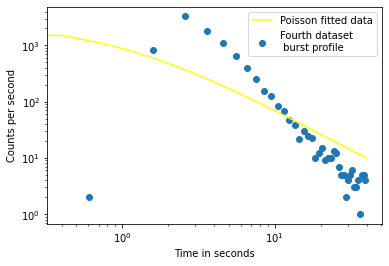

In [65]:
t=np.linspace(0,40,100)
result.x=parm
plt.figure()
plt.scatter((tedg4[:-1]+tedg4[1:])/2,tc4,label="Fourth dataset\n burst profile")
plt.plot(t,pl_model(t,parm),c='yellow',label="Poisson fitted data")
plt.legend(fontsize=10)
plt.xlabel('Time in seconds')
plt.ylabel('Counts per second')
plt.xscale('log')
plt.yscale('log')

Although our fittings are not the greattest possible we are able to make more observation with them. The first observation is that the power law indeces come out about the same in the second and third dataset. This does not happen for the first and fourth dataset but both of the power law indices in those cases are smaller than those from the second and third database. So because for different energies we obtain different indices we are going to see how the time affects the energy spectrum in the next task.

## Task 4

In this task we are going to split the datasets from 0 to 20 and 20 to 40 seconds and then we are going to plot the energy spectrum for each given time period in order to examine if the time spectrum changes with time.

Now we begin with the first dataset. The first step of our analysis is to first split the dataset.

In [66]:
data_1 = pd.read_csv('Sidiras_grb1.txt', delim_whitespace=True, skiprows=2, skipfooter=2, engine='python',
names=['Time','Energy'],
  index_col=False, na_values='-')
data_11=data_1[data_1.Time<20]
data_12=data_1[data_1.Time>=20]

Now we are going to plot and fit the spectrum for the first dataset and for time<20 seconds.

In [67]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_11['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

Now we are going to plot our data in order to get an idea of how we are going to plot it.

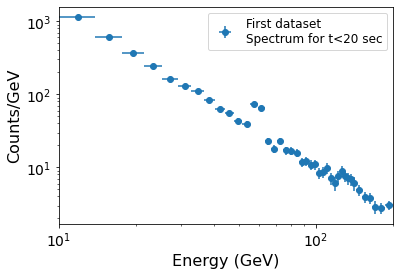

In [68]:
plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='First dataset \nSpectrum for t<20 sec')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               

It has the same form as the one in task 1 so we are going to use the same fitting again.

Covariance matrix: 
  [[ 1.56093681e+08 -1.79034301e+02  4.71614019e+04  7.39593609e+00]
 [-1.79034301e+02  2.14082692e-04 -6.40477627e-02 -5.48232282e-06]
 [ 4.71614019e+04 -6.40477627e-02  6.38795739e+02 -1.24238294e-01]
 [ 7.39593609e+00 -5.48232282e-06 -1.24238294e-01  4.64275795e-02]]

Normalisation at 1 GeV = 278182.8088938972 +/- 12493.745684130985
Power-law index = -2.2338768707249947 +/- 0.014631564906434498
Normalisation of Gaussian= 313.4765828692046 +/- 25.27440878168303
Gaussian centroid(in GeV)=59.196576871175274 +/- 0.21547060007979454
Minimum Chi-squared = 38.02591487768778 for 37 d.o.f.
The goodness of fit is: 0.42246334825740867


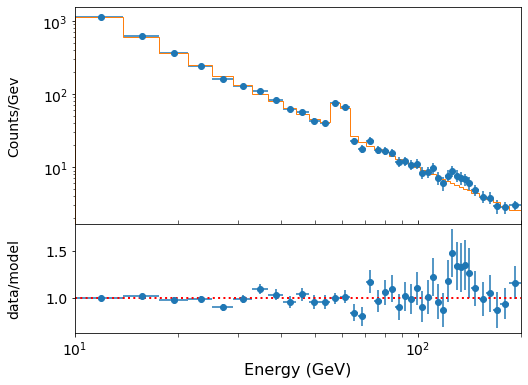

In [69]:
model = gaussian_model
p0 = [20000,-2,300,60]  # Initial  parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("\nNormalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
print("Normalisation of Gaussian= "+str(ml_cfpars[2])+" +/- "+str(err[2]))
print("Gaussian centroid(in GeV)="+str(ml_cfpars[3])+" +/- "+str(err[3]))
minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

In this case we got a much better fit that when we did for the whole 40 seconds in the task 1. Now lets see the spectrum for the time period 20 to 40 sec. 

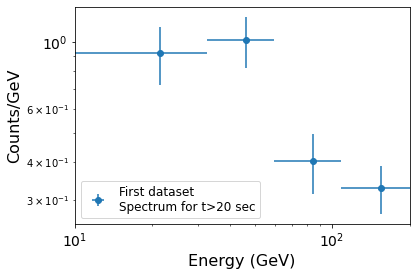

In [70]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_12['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='First dataset \nSpectrum for t>20 sec')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


For the first dataset at least we can see that the biggest part of the spectrum comes out from the 0-20 seconds period while the other half is basically noise(due to the  low count measurments and the huge errors.Also, we can say that the second half of our measurments is what affects the spectrum in the Task 1 and it is the reason behind our terible fit that we obtained for the first dataset. So at least for the first data set we can see that the spectrum indeed changes a lot during the burst. During the first half of the burst (0-20 seconds) we obtain most of the spectrum and the information that the gamma ray burst has to offer, while in the second half (20-40 seconds) we mostly obtain background measurments and noise. 

Now we continue with the second dataset. The first step is to split the dataset in two time periods 0-20 seconds and 20-40 seconds.

In [71]:
data_2 = pd.read_csv('Sidiras_grb2.txt', delim_whitespace=True, skiprows=2, skipfooter=2, engine='python',
names=['Time','Energy'],
  index_col=False, na_values='-')
data_21=data_2[data_2.Time<20]
data_22=data_2[data_2.Time>=20]

Now we are going to obtain the spectrum for the first half.

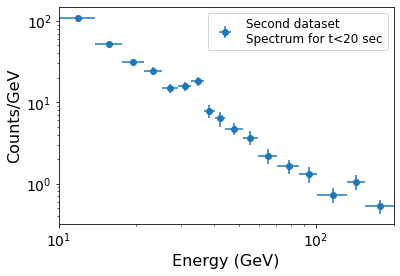

In [72]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_21['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Second dataset \nSpectrum for t<20 sec')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


Now we are going to fit the spectrum. At first glance it seems like the spectrum we obtained in Task 1 from the second data set.

Covariance matrix: 
  [[ 1.81422243e+07 -1.83276472e+02  7.35224577e+03  1.22482029e+01]
 [-1.83276472e+02  1.91957733e-03 -9.36859606e-02  4.84323836e-05]
 [ 7.35224577e+03 -9.36859606e-02  9.25470234e+01 -5.46743476e-01]
 [ 1.22482029e+01  4.84323836e-05 -5.46743476e-01  2.34869690e-01]]

Normalisation at 1 GeV = 32944.66033076643 +/- 4259.368997755446
Power-law index = -2.3338807879121544 +/- 0.04381298126299808
Normalisation of Gaussian= 57.05150748298751 +/- 9.620136351220799
Gaussian centroid(in GeV)=33.80488464121598 +/- 0.48463356215058534
Minimum Chi-squared = 7.686150050877376 for 13 d.o.f.
The goodness of fit is: 0.8634289372915173


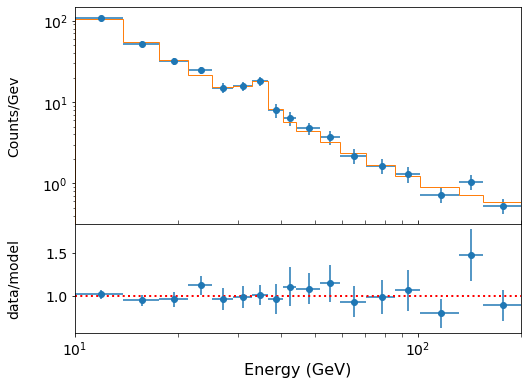

In [73]:
model = gaussian_model
p0 = [20000,-2,300,35]  # Initial  parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("\nNormalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
print("Normalisation of Gaussian= "+str(ml_cfpars[2])+" +/- "+str(err[2]))
print("Gaussian centroid(in GeV)="+str(ml_cfpars[3])+" +/- "+str(err[3]))
minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

We have obtained a really good fit and once again it is a better one frome that in the first Task 1, because the goodness of the fit parameter has become even greatter. Now we are going to plot the spectrum for the other half of the burst.

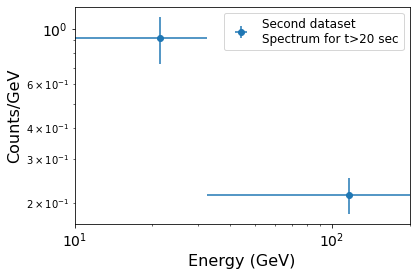

In [74]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_22['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Second dataset \nSpectrum for t>20 sec')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


In this case we obtain a spectrum with only two data points which we can see have huge errors. So this may be the reason why in the first task we obtained a really good fit the second data set and not for the first because in the second half of the first data set there were many more data points.

We continue our analysis with the third data set. Following the same steps as before first we have to split the data.

In [75]:
data_3 = pd.read_csv('Sidiras_grb3.txt', delim_whitespace=True, skiprows=2, skipfooter=2, engine='python',
names=['Time','Energy'],
  index_col=False, na_values='-')
data_31=data_3[data_3.Time<20]
data_32=data_3[data_3.Time>=20]

Now we are going to plot the spectrum for the first half of the burst.

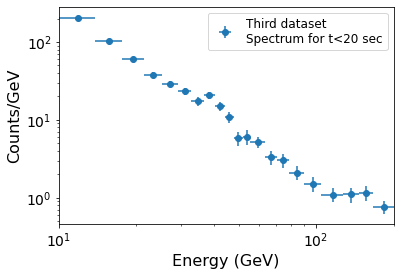

In [76]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_31['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Third dataset \nSpectrum for t<20 sec')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


Once again at first glance it really looks like the spectrum we obtained in task 1 fromthe third dataset. We are going to fit it to examine for possible changes.

Covariance matrix: 
  [[ 3.67595927e+07 -1.71409197e+02  1.09411922e+04  3.91363715e+01]
 [-1.71409197e+02  8.28780932e-04 -6.15803646e-02 -1.62297724e-04]
 [ 1.09411922e+04 -6.15803646e-02  8.68767583e+01 -1.37768248e-01]
 [ 3.91363715e+01 -1.62297724e-04 -1.37768248e-01  2.16802487e-01]]

Normalisation at 1 GeV = 71053.77269629939 +/- 6062.9689712619465
Power-law index = -2.3779502586958046 +/- 0.028788555578740733
Normalisation of Gaussian= 54.96278136303262 +/- 9.32077026501927
Gaussian centroid(in GeV)=39.69913711390649 +/- 0.46562053977174556
Minimum Chi-squared = 8.7072861484642 for 17 d.o.f.
The goodness of fit is: 0.9489996293552766


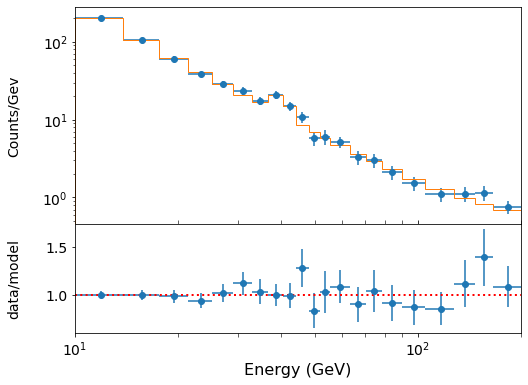

In [77]:
model = gaussian_model
p0 = [20000,-2,300,40]  # Initial  parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("\nNormalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
print("Normalisation of Gaussian= "+str(ml_cfpars[2])+" +/- "+str(err[2]))
print("Gaussian centroid(in GeV)="+str(ml_cfpars[3])+" +/- "+str(err[3]))
minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

So we can see that in this case, as well as in the others so far, that the goodness parameter becomes even greater comparing to the one we obtained from the fitting of the third dataset in task 1. Now we are going to plot the spectrum from the second half of the burst, to see what the second half consists of.

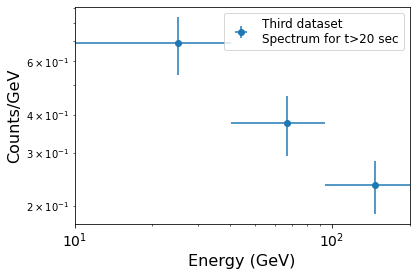

In [78]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_32['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Third dataset \nSpectrum for t>20 sec')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


In the plot above we can see that the second half of the burst mostly constists of low counts measurments with huge error bars, which is what has happened so far for the other datasets as well. But in this case the data points we obtain from the second half are not so randomly position as in the other cases and that is why obtain the highest goodness of fit in the first task compairing to the other datasets.

Now for the  fourth data set we start by splitting the dataset.

In [79]:
data_4 = pd.read_csv('Sidiras_grb4.txt', delim_whitespace=True, skiprows=2, skipfooter=2, engine='python',
names=['Time','Energy'],
  index_col=False, na_values='-')
data_41=data_4[data_4.Time<20]
data_42=data_4[data_4.Time>=20]

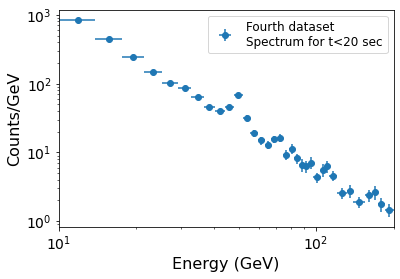

In [80]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_41['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Fourth dataset \nSpectrum for t<20 sec')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


As it happened before the spectrum we obtained from the first half of the burst for the fourth data set, looks like the spectrum we obtain frome the whole data set in task 1. So we are going to fit it and examine for possible changes.

Covariance matrix: 
  [[ 4.06416948e+08 -4.35586939e+02  8.86562052e+04 -3.41151038e+01]
 [-4.35586939e+02  4.84608550e-04 -1.11611175e-01  5.96328131e-05]
 [ 8.86562052e+04 -1.11611175e-01  6.85299571e+02 -5.51408187e-01]
 [-3.41151038e+01  5.96328131e-05 -5.51408187e-01  9.94429202e-02]]

Normalisation at 1 GeV = 306409.2112316353 +/- 20159.78541654822
Power-law index = -2.3996366471419788 +/- 0.022013826331247648
Normalisation of Gaussian= 251.16452048818928 +/- 26.17822704826115
Gaussian centroid(in GeV)=49.61449941035358 +/- 0.3153457153541031
Minimum Chi-squared = 39.44016884503297 for 30 d.o.f.
The goodness of fit is: 0.11617024017572965


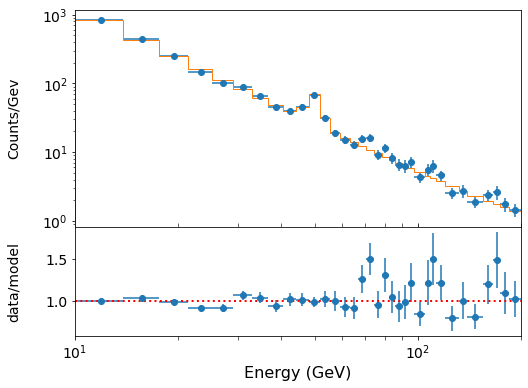

In [81]:
model = gaussian_model
p0 = [20000,-2,300,50]  # Initial  parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
err = np.sqrt(np.diag(ml_cfcovar))
print("Covariance matrix: \n ",ml_cfcovar)

print("\nNormalisation at 1 GeV = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
print("Normalisation of Gaussian= "+str(ml_cfpars[2])+" +/- "+str(err[2]))
print("Gaussian centroid(in GeV)="+str(ml_cfpars[3])+" +/- "+str(err[3]))
minchisq = np.sum(((cdens - model_int_cf(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))
best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
plot_spec_model(edges2,cdens,cdens_err,best_model)

As it has  happened before we see an improvement on the goodness of the fit, which was expected considering the cases above. Now we are going to plot the other half to see what it consists of.

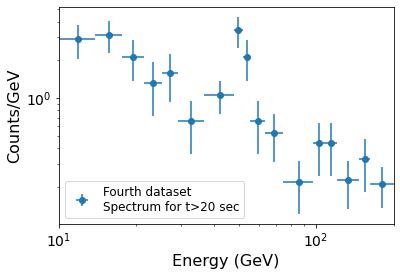

In [82]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_42['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 5
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Fourth dataset \nSpectrum for t>20 sec')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


In this case we have changed the minimum counts per bins but still as we can see from the plot above we obtain low counts data points with big error bars. These data points are responsible for the bad fit we get for the fourth dataset. 

Considering all of the above we can see that most of gamma ray spectrum is obtained at the first 20 seconds of the burst so in that time period it should change because each photon that is measured at that time period plays an important role in the formation of the continuum and the formation of the emission lines of the spectrum. In the next 20 seconds of our burst the counts drops dramaticaly comparing them to the first half. So in the second half of the burst the spectrum does not change that much.Part of it is because the way we have splitted the data there are not too many data points in the second half. So although the analysis above explains the terrible fits we got in task one but it does not give us any details about how the spectrum evolves during the burst. So now we are going to split data by greater or lower than the mean value of time. In that way we are going to have a lot more data points in the second half and maybe we will manage to obtain a much more detailed description of the evolution of the spectrum during the burst.

In [83]:
a=np.mean(data_1['Time'])
print("The mean is ", a," sec")
data_11=data_1[data_1.Time<a]
data_12=data_1[data_1.Time>=a]

The mean is  2.559174608877902  sec


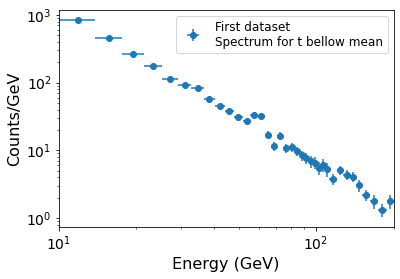

In [84]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_11['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='First dataset \nSpectrum for t bellow mean')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


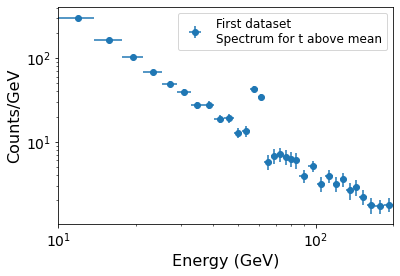

In [85]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_12['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='First dataset \nSpectrum for t above mean')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


Comparing the last two plots we can see that bellow the mean which is 2.5 seconds, so bellow the 2.5 seconds the emission line has not yet formed. But in the spectrum after 2.5 seconds we can see that the emission line around 60 GeV has fully formed. So we can say that the emission of the emission line happens after the mean time or in this case afte two seconds. Now we are going to examine if this happens for the other data sets as well. Firstly we begin with the second dataset.

Firstly we split the second data set.

In [86]:
a=np.mean(data_2['Time'])
print("The mean is ", a," sec")
data_21=data_2[data_2.Time<a]
data_22=data_2[data_2.Time>=a]

The mean is  5.9719978030303045  sec


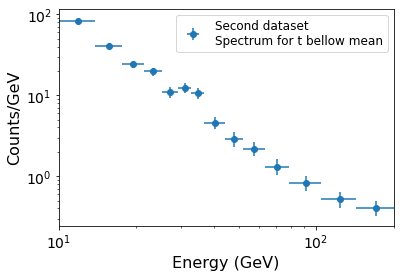

In [87]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_21['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Second dataset \nSpectrum for t bellow mean')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


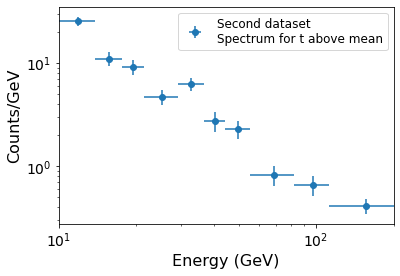

In [88]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_22['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Second dataset \nSpectrum for t above mean')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


We can say the same thing happening in this  as well. So the emission line that we are expecting in the spectrum of the second data set forms after 6 seconds which is the mean value of the time measurments.

Now we are going to do the same analysis for the the third dataset.

In [89]:
a=np.mean(data_3['Time'])
print("The mean is ", a," sec")
data_31=data_3[data_3.Time<a]
data_32=data_3[data_3.Time>=a]

The mean is  4.3749903516295054  sec


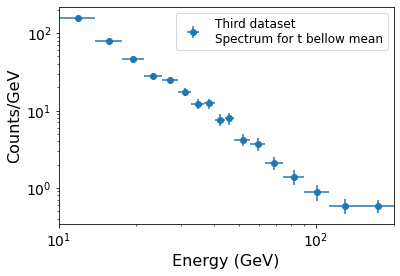

In [90]:
min, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_31['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Third dataset \nSpectrum for t bellow mean')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


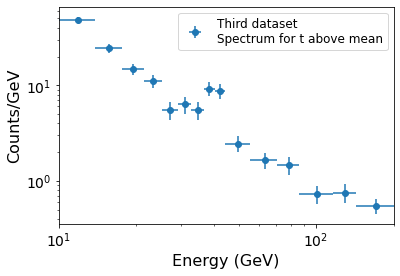

In [91]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_32['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Third dataset \nSpectrum for t above mean')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


And in this case we can see that the emission line at 35 GeV that we were expecting forms for time above the mean value of the time measurments. Now we are going to test if the same thing happens for the the fourth dataset.

In [92]:
a=np.mean(data_4['Time'])
print("The mean is ", a," sec")
data_41=data_4[data_4.Time<a]
data_42=data_4[data_4.Time>=a]

The mean is  4.415148579920731  sec


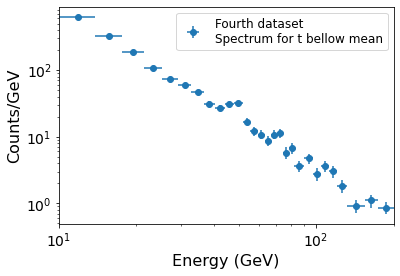

In [93]:
min, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_41['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Fourth dataset \nSpectrum for t bellow mean')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


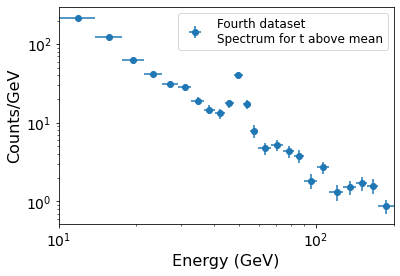

In [94]:
emin, emax = 10., 200.
nbins = 50
counts, edges = np.histogram(data_42['Energy'], bins=nbins, range=[emin,emax], density=False)
mincounts = 20
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2)
cdens = counts2/bwidths#yval
cdens_err = np.sqrt(counts2)/bwidths#dy
energies = (edges2[:-1]+edges2[1:])/2#xval

plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o',label='Fourth dataset \nSpectrum for t above mean')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()               


The emission line at 50 GeV of the fourth dataset is emitted after 4.4 seconds in the burst. With other words as with the cases above we can see that the emission happens after the mean value of our time measurments.

 We have to say there is no need to test for the significances of these emission lines because we have already did in task 1.
 To conclude from the analysis above we have found out that must of the photon of the burst are emitted in the first half(the first 20 second ofour measurment). Also, and most importanly we have seen that the emission line of the spectrum is emitted after the mean value of time of each dataset.